**Road detection**

***`Preprocessing`***

Rasterisation

In [ ]:
import ezdxf
import numpy as np
import cv2
import rasterio
import os
ROAD_LAYERS = ["ROUTE","CHEMIN"]

TIF_file = r"C:\Users\DELL\Desktop\PLAN TOPO\17\ORTHOMOSAÏQUE_2154_CVE_1498.tif"
dxf_file= r"C:\Users\DELL\Desktop\Stage\17.dxf"
output_dir = r"C:\Users\DELL\Desktop"

def map_to_pixel(x, y, bounds, width, height):
    min_x, min_y, max_x, max_y = bounds
    col = int((x - min_x) / (max_x - min_x) * width)
    row = int((max_y - y) / (max_y - min_y) * height)
    return col, row

def extract_and_connect_segments_same_layer(dxf_file, tif_file):
    mask_filename = os.path.splitext(os.path.basename(dxf_file))[0] + ".png"
    mask_path = os.path.join(output_dir, mask_filename)
    print("Loading DXF and extracting segments...")
    doc = ezdxf.readfile(dxf_file)
    msp = doc.modelspace()

    with rasterio.open(tif_file) as dataset:
        width, height = dataset.width, dataset.height
        bounds = (dataset.bounds.left, dataset.bounds.bottom, dataset.bounds.right, dataset.bounds.top)

    mask = np.zeros((height, width), dtype=np.uint8)

    segments = []
    endpoints = []  # (x,y, segment_idx, is_start_point, layer)

    # Extract segments and their layers
    for entity in msp:
        if entity.dxftype() in ('LINE', 'LWPOLYLINE', 'POLYLINE'):
            layer_name = entity.dxf.layer.upper()
            for entity in msp:
                dxftype = entity.dxftype()
                if dxftype == 'LINE':
                    layer_name = entity.dxf.layer.upper()
                    if layer_name in ROAD_LAYERS:
                        points = [(entity.dxf.start.x, entity.dxf.start.y), (entity.dxf.end.x, entity.dxf.end.y)]
                        if len(points) >= 2:
                            segments.append((points, layer_name))
                            idx = len(segments) - 1
                            endpoints.append((points[0], idx, True, layer_name))
                            endpoints.append((points[-1], idx, False, layer_name))

                elif dxftype == 'LWPOLYLINE':
                    layer_name = entity.dxf.layer.upper()
                    if layer_name in ROAD_LAYERS:
                        points = [(pt[0], pt[1]) for pt in entity.get_points()]
                        if len(points) >= 2:
                            segments.append((points, layer_name))
                            idx = len(segments) - 1
                            endpoints.append((points[0], idx, True, layer_name))
                            endpoints.append((points[-1], idx, False, layer_name))

                elif dxftype == 'POLYLINE':
                    layer_name = entity.dxf.layer.upper()
                    if layer_name in ROAD_LAYERS:
                        points = [(v.dxf.location.x, v.dxf.location.y) for v in entity.vertices]
                        if len(points) >= 2:
                            segments.append((points, layer_name))
                            idx = len(segments) - 1
                            endpoints.append((points[0], idx, True, layer_name))
                            endpoints.append((points[-1], idx, False, layer_name))

                # skip any other type silently

                # if len(points) >= 2:
                #     segments.append((points, layer_name))
                #     idx = len(segments) - 1
                #     endpoints.append((points[0], idx, True, layer_name))
                #     endpoints.append((points[-1], idx, False, layer_name))

    print(f"Extracted {len(segments)} segments.")

    # Map points to pixel coordinates
    segments_pixels = []
    for seg_pts, _ in segments:
        pix_pts = [map_to_pixel(x, y, bounds, width, height) for (x,y) in seg_pts]
        segments_pixels.append(pix_pts)

    endpoints_pixels = []
    for (pt, seg_idx, is_start, layer) in endpoints:
        x, y = pt
        col, row = map_to_pixel(x, y, bounds, width, height)
        endpoints_pixels.append({'pos': (col, row), 'seg_idx': seg_idx, 'is_start': is_start, 'layer': layer, 'connected': False})

    # Draw original segments
    for pix_pts in segments_pixels:
        pts_array = np.array(pix_pts, np.int32)
        cv2.polylines(mask, [pts_array], isClosed=False, color=255, thickness=10)

    print("Connecting endpoints one-to-one within the same layer...")

    # For each endpoint, find the closest unconnected endpoint in the same layer and connect it
    for i, ep1 in enumerate(endpoints_pixels):
        if ep1['connected']:
            continue

        min_dist = None
        closest_idx = None
        x1, y1 = ep1['pos']
        layer1 = ep1['layer']

        for j, ep2 in enumerate(endpoints_pixels):
            if i == j:
                continue
            if ep2['connected']:
                continue
            if ep2['layer'] != layer1:
                continue
            x2, y2 = ep2['pos']
            dist = np.hypot(x1 - x2, y1 - y2)
            if (min_dist is None) or (dist < min_dist):
                min_dist = dist
                closest_idx = j

        if closest_idx is not None:
            ep2 = endpoints_pixels[closest_idx]
            cv2.line(mask, ep1['pos'], ep2['pos'], color=255, thickness=10)
            ep1['connected'] = True
            ep2['connected'] = True

        # Find contours (closed polygons) in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

        # Fill all found contours with white color (255)
        for cnt in contours:
            cv2.drawContours(mask, [cnt], 0, 255, thickness=cv2.FILLED)

        cv2.imwrite(mask_path, mask)
        print("Mask with filled polygons saved as 'mask_connected_filled.png'")

# Example usage
extract_and_connect_segments_same_layer(
    dxf_file,
    TIF_file
)


Tiling and overlapping

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from PIL import Image
import warnings
from rasterio.errors import NotGeoreferencedWarning

warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

# Tile size and overlap ratio
TILE_SIZE = 1024
OVERLAP_RATIO = 0.2

# Output directories
OUTPUT_IMAGE_DIR = r"C:\Users\DELL\Desktop\Stage\1\images"
OUTPUT_MASK_DIR = r"C:\Users\DELL\Desktop\Stage\1\masks"

os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_MASK_DIR, exist_ok=True)

def tile_image_and_mask(tif_path, mask_path):
    """
    Tile a large TIF image (P mode, RGB, or grayscale) and its mask with overlap.
    """
    with rasterio.open(tif_path) as tif, rasterio.open(mask_path) as mask_ds:
        h, w = tif.height, tif.width
        base_name = os.path.splitext(os.path.basename(tif_path))[0]

        if (h, w) != (mask_ds.height, mask_ds.width):
            print(f"⚠️ Size mismatch between {os.path.basename(tif_path)} and mask. Skipping.")
            return

        stride = int(TILE_SIZE * (1 - OVERLAP_RATIO))
        tile_id = 0

        for i in range(0, h - TILE_SIZE + 1, stride):
            for j in range(0, w - TILE_SIZE + 1, stride):
                window = Window(j, i, TILE_SIZE, TILE_SIZE)

                if tif.count >= 3:
                    # RGB image
                    img_tile = tif.read([1, 2, 3], window=window)
                    img_tile = np.transpose(img_tile, (1, 2, 0))
                    img_pil = Image.fromarray(img_tile)
                elif tif.count == 1:
                    # P mode / grayscale image
                    band = tif.read(1, window=window)
                    img_pil = Image.fromarray(band).convert("RGB")
                else:
                    print(f"❌ Unsupported number of bands: {tif.count}")
                    return

                mask_tile = mask_ds.read(1, window=window)

                img_tile_path = os.path.join(OUTPUT_IMAGE_DIR, f"{base_name}_{tile_id}.png")
                mask_tile_path = os.path.join(OUTPUT_MASK_DIR, f"{base_name}_{tile_id}.png")

                img_pil.save(img_tile_path)
                Image.fromarray(mask_tile).convert("L").save(mask_tile_path)

                tile_id += 1

        print(f" Tiled {base_name}: {tile_id} tiles created ({TILE_SIZE}×{TILE_SIZE}, {OVERLAP_RATIO*100:.0f}% overlap).")

# Example usage:
mask_file = r"C:\Users\DELL\Desktop\Stage\1.png"
tif_file = r"C:\Users\DELL\Desktop\Stage\1.tif"
tile_image_and_mask(tif_file, mask_file)



Padding

In [ ]:
import os
import cv2
import numpy as np

image_folder = r"C:\Users\DELL\Desktop\data_stage\images"
mask_folder = r"C:\Users\DELL\Desktop\data_stage\masks"
TARGET_SIZE = 1024

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    mask_path  = os.path.join(mask_folder, image_name.replace('_img', '_mask'))

    # Load image and mask
    img  = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    h, w = img.shape[:2]

    if h < TARGET_SIZE or w < TARGET_SIZE:
        # Calculate padding for each side
        pad_bottom = TARGET_SIZE - h if h < TARGET_SIZE else 0
        pad_right  = TARGET_SIZE - w if w < TARGET_SIZE else 0

        # Pad image with white (255,255,255)
        img_padded = cv2.copyMakeBorder(img, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

        # Pad mask with white (255)
        mask_padded = cv2.copyMakeBorder(mask, 0, pad_bottom, 0, pad_right, cv2.BORDER_CONSTANT, value=255)

        # Save back
        cv2.imwrite(image_path, img_padded)
        cv2.imwrite(mask_path, mask_padded)

print("✅ All small images and masks are padded .")

deleting white and black images

In [ ]:
import os
import cv2
import numpy as np

image_folder = r"C:\Users\DELL\Desktop\Stage\1\images"
mask_folder = r"C:\Users\DELL\Desktop\Stage\1\masks"

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    mask_path  = os.path.join(mask_folder, image_name.replace('_img', '_mask'))

    # Load image and mask
    img = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if image is fully white AND mask has no road pixels
    if (np.all(img > 250) or np.all(img == 0)) and np.all(mask == 0):
        os.remove(image_path)
        os.remove(mask_path)

print(" Cleaned up empty white image tiles with empty masks.")

Splitting data between training and validation

In [ ]:
import os
import shutil
import random

def train_val_split(data_dir, val_ratio=0.2, seed=42):
    random.seed(seed)

    img_dir = os.path.join(data_dir, 'images')
    mask_dir = os.path.join(data_dir, 'masks')

    images = os.listdir(img_dir)
    images = [f for f in images if f.endswith(('.png', '.jpg', '.jpeg', '.tif'))]

    random.shuffle(images)

    val_count = int(len(images) * val_ratio)
    val_images = images[:val_count]
    train_images = images[val_count:]

    # Create directories
    for split in ['train', 'val']:
        for folder in ['images', 'masks']:
            os.makedirs(os.path.join(data_dir, split, folder), exist_ok=True)

    # Move files
    for img_name in train_images:
        shutil.move(os.path.join(img_dir, img_name), os.path.join(data_dir, 'train', 'images', img_name))
        shutil.move(os.path.join(mask_dir, img_name), os.path.join(data_dir, 'train', 'masks', img_name))

    for img_name in val_images:
        shutil.move(os.path.join(img_dir, img_name), os.path.join(data_dir, 'val', 'images', img_name))
        shutil.move(os.path.join(mask_dir, img_name), os.path.join(data_dir, 'val', 'masks', img_name))

    print(f"Train set size: {len(train_images)}")
    print(f"Validation set size: {len(val_images)}")

# Usage example:
train_val_split(r"C:\Users\DELL\Desktop\Stage\1", val_ratio=0.2)

checking the number of images

In [ ]:
import os

def count_images_and_masks(base_dir):
    sets = ['train', 'val']
    for split in sets:
        images_dir = os.path.join(base_dir, split, 'images')
        masks_dir  = os.path.join(base_dir, split, 'masks')

        num_images = len([f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))])
        num_masks  = len([f for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))])

        print(f"{split.upper()} SET:")
        print(f"  Number of images: {num_images}")
        print(f"  Number of masks : {num_masks}\n")

# ✅ Usage:
count_images_and_masks("/kaggle/working/dataset_split")

deleting some images in order to make the number of images a multiple of the batchs

In [ ]:
import os
import numpy as np
from PIL import Image

def delete_one_black_mask_and_image(train_dir):
    images_dir = os.path.join(train_dir, 'images')
    masks_dir = os.path.join(train_dir, 'masks')

    for mask_name in os.listdir(masks_dir):
        mask_path = os.path.join(masks_dir, mask_name)

        mask = Image.open(mask_path).convert('L')
        mask_np = np.array(mask)

        if np.all(mask_np == 0):
            # Delete mask
            os.remove(mask_path)
            print(f"Deleted mask: {mask_path}")

            # Delete corresponding image
            image_path = os.path.join(images_dir, mask_name)
            if os.path.exists(image_path):
                os.remove(image_path)
                print(f"Deleted image: {image_path}")
            else:
                print(f"Image not found for mask: {mask_name}")

            break  # Only delete one pair and then stop

# Example usage:
delete_one_black_mask_and_image('/kaggle/working/dataset_split/train')

# ***Training***

**1/ U-net**

In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    """(conv => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.down1 = DoubleConv(n_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up_conv4 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv3 = DoubleConv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv1 = DoubleConv(128, 64)

        self.out_conv = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))
        bottleneck = self.bottleneck(self.pool4(d4))

        u4 = self.up4(bottleneck)
        u4 = self.up_conv4(torch.cat([u4, d4], dim=1))
        u3 = self.up3(u4)
        u3 = self.up_conv3(torch.cat([u3, d3], dim=1))
        u2 = self.up2(u3)
        u2 = self.up_conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(u2)
        u1 = self.up_conv1(torch.cat([u1, d1], dim=1))

        return self.out_conv(u1)

from torch.utils.data import Dataset
import cv2
import os
import torch

class RoadDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir  = masks_dir
        self.image_names = os.listdir(images_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path  = os.path.join(self.images_dir, self.image_names[idx])
        mask_path = os.path.join(self.masks_dir, self.image_names[idx].replace('_img', '_mask'))

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = image / 255.0  # Normalize to [0,1]
        mask  = (mask < 128).astype('float32')  # Assuming road is black (0), background white (255)

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask  = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask



import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Paths
train_images = r"/content/data/train/images"
train_masks = r"/content/data/train/masks"
val_images = r"/content/data/val/images"
val_masks = r"/content/data/val/masks"

# Datasets
train_dataset = RoadDataset(train_images, train_masks)
val_dataset = RoadDataset(val_images, val_masks)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model
model = UNet(n_channels=1, n_classes=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Training loop
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")
    # Directory to save checkpoints
    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Save checkpoint after each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f'unet_epoch_{epoch+1}.pth')
    torch.save(model.state_dict(), checkpoint_path)

    print(f"✅ Saved checkpoint: {checkpoint_path}")
torch.save(model.state_dict(), "unet_road_detection.pth")
print("✅ Model saved as unet_road_detection.pth")



Using device: cuda
Epoch 1/5 - Training: 100%|██████████| 4020/4020 [58:06<00:00,  1.15it/s]
Epoch 1, Train Loss: 0.1150
✅ Saved checkpoint: checkpoints/unet_epoch_1.pth

---


Epoch 2/5 - Training: 100%|██████████| 4020/4020 [57:12<00:00,  1.17it/s]
Epoch 2, Train Loss: 0.0935
✅ Saved checkpoint: checkpoints/unet_epoch_2.pth

---


Epoch 3/5 - Training: 100%|██████████| 4020/4020 [59:31<00:00,  1.13it/s]
Epoch 3, Train Loss: 0.0843
✅ Saved checkpoint: /content/checkpoints/unet_epoch_3.pth

---


Epoch 4/5 - Training: 100%|██████████| 4020/4020 [58:57<00:00,  1.14it/s]
Epoch 4, Train Loss: 0.0769
✅ Saved checkpoint: /content/checkpoints/unet_epoch_4.pth

---


Epoch 5/5 - Training: 100%|██████████| 4020/4020 [58:42<00:00,  1.14it/s]
Epoch 5, Train Loss: 0.0708
✅ Saved checkpoint: /content/checkpoints/unet_epoch_5.pth

---


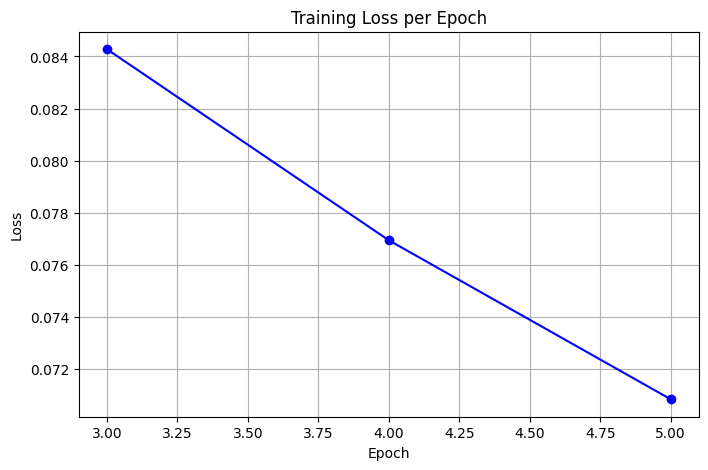

Inference with u-net

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import rasterio

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load trained model
model = UNet(n_channels=1, n_classes=1).to(device)
checkpoint_path = "/content/unet_epoch_6.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"✅ Loaded model checkpoint: {checkpoint_path}")

# Function to preprocess and predict a tile
def predict_tile(model, tile, device):
    tile_tensor = torch.from_numpy(tile).unsqueeze(0).unsqueeze(0).float().to(device)
    with torch.no_grad():
        output = model(tile_tensor)
        prob = torch.sigmoid(output).cpu().numpy().squeeze()
    return (prob > 0.5).astype(np.uint8)  # Binarize at 0.5

# Function to run sliding window inference
def sliding_window_inference_tif(model, tif_path, tile_size=512):
    with rasterio.open(tif_path) as src:
        image = src.read(1)  # Read first band (grayscale)
        meta = src.meta
        h, w = image.shape

    # Pad image to multiple of tile_size if needed
    pad_h = (tile_size - h % tile_size) % tile_size
    pad_w = (tile_size - w % tile_size) % tile_size
    image_padded = np.pad(image, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=255)
    H, W = image_padded.shape

    print(f"Image size: {h}x{w} → Padded to: {H}x{W}")

    # Initialize empty mask for prediction
    mask_pred = np.zeros((H, W), dtype=np.uint8)

    # Slide over image
    for y in range(0, H, tile_size):
        for x in range(0, W, tile_size):
            tile = image_padded[y:y+tile_size, x:x+tile_size].astype(np.float32) / 255.0
            pred = predict_tile(model, tile, device)
            mask_pred[y:y+tile_size, x:x+tile_size] = (pred * 255).astype(np.uint8)

    # Remove padding to original size
    mask_pred = mask_pred[:h, :w]

    return image, mask_pred, meta



# === Inference ===
image_path = "/content/ORTHOMOSAÏQUE_2154_CVE_1498.tif"  # 👈 Replace with your test image path
orig_image, predicted_mask, meta = sliding_window_inference_tif(model, image_path, tile_size=512)

# === Display results ===
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(orig_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Predicted Road Mask')
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')
plt.show()

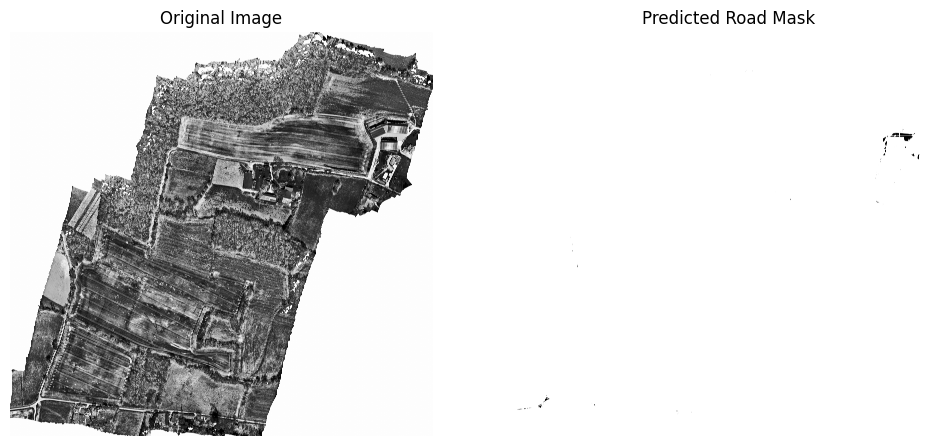

worse than expected and it took a lot of time (1h per epoch)

**2/ Pretrained model: Deeplab v3+ +resnet34**

In [ ]:
import segmentation_models_pytorch as smp
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm

# Your dataset class must be defined somewhere (RoadDataset)

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,  # 3 if RGB, 1 if grayscale
    classes=1,      # Binary mask
)

dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss  = nn.BCEWithLogitsLoss()

def combined_loss(outputs, targets):
    loss1 = dice_loss(outputs, targets)
    loss2 = bce_loss(outputs, targets)
    return loss1 + loss2

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataset = RoadDataset("/kaggle/working/dataset_split/train/images", "/kaggle/working/dataset_split/train/masks")
val_dataset   = RoadDataset("/kaggle/working/dataset_split/val/images", "/kaggle/working/dataset_split/val/masks")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, masks in tqdm.tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        # Do NOT squeeze here to keep shape (B, 1, H, W)
        # outputs = outputs.squeeze(1)

        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # outputs = outputs.squeeze(1)  # again, keep shape consistent
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save checkpoint
    torch.save(model.state_dict(), f"/kaggle/working/deeplabv3_epoch{epoch+1}.pth")

**inference after 15 epochs**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image

# === Load trained model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,     # 1 if grayscale
    classes=1
)
model.load_state_dict(torch.load("/kaggle/working/deeplabv3_epoch15.pth", map_location=device))
model.to(device)
model.eval()

# === Sliding window inference ===
def sliding_window_inference_tif(tif_path, tile_size=1024, threshold=0.5):
    with rasterio.open(tif_path) as src:
        img = src.read([1, 2, 3])  # RGB
        img = np.transpose(img, (1, 2, 0))  # (H, W, C)
        meta = src.meta

    orig_height, orig_width, _ = img.shape

    # Pad image if needed
    pad_height = (tile_size - orig_height % tile_size) % tile_size
    pad_width  = (tile_size - orig_width % tile_size) % tile_size
    padded_img = np.pad(img, ((0, pad_height), (0, pad_width), (0,0)), mode='constant', constant_values=0)

    H, W, _ = padded_img.shape
    mask_pred = np.zeros((H, W), dtype=np.float32)

    preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])

    for y in range(0, H, tile_size):
        for x in range(0, W, tile_size):
            tile = padded_img[y:y+tile_size, x:x+tile_size, :]
            input_tensor = preprocess(tile).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
                prob = torch.sigmoid(output).cpu().numpy().squeeze()

            mask_pred[y:y+tile_size, x:x+tile_size] = prob

    # Crop back to original size
    mask_pred = mask_pred[:orig_height, :orig_width]

    # Binarize with threshold
    binary_mask = (mask_pred > threshold).astype(np.uint8) * 255

    return img, binary_mask

# === Run inference ===
tif_path = "/kaggle/input/inference2/18.tif"  # <-- put your TIF path here
original_image, predicted_mask = sliding_window_inference_tif(tif_path)

# === Superimpose the mask ===
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Overlay")
overlay = original_image.copy()
overlay[predicted_mask == 255] = [255, 0, 0]  # red overlay on detected roads
plt.imshow(overlay)

plt.tight_layout()
plt.show()


impressive result but with some noise

the model is still learning (best val loss is the 15th)
so i'll try to tain it for more 5 epochs

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import tqdm
from torch.utils.data import DataLoader
# === Load trained model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,     # 1 if grayscale
    classes=1
)

dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss  = nn.BCEWithLogitsLoss()

def combined_loss(outputs, targets):
    loss1 = dice_loss(outputs, targets)
    loss2 = bce_loss(outputs, targets)
    return loss1 + loss2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataset = RoadDataset("/kaggle/working/dataset_split/train/images", "/kaggle/working/dataset_split/train/masks")
val_dataset   = RoadDataset("/kaggle/working/dataset_split/val/images", "/kaggle/working/dataset_split/val/masks")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)

model.load_state_dict(torch.load("/kaggle/input/deeplabv3-epoch15-pth/deeplabv3_epoch15.pth", map_location=device))
model.to(device)

epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, masks in tqdm.tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        # Do NOT squeeze here to keep shape (B, 1, H, W)
        # outputs = outputs.squeeze(1)

        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # outputs = outputs.squeeze(1)  # again, keep shape consistent
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save checkpoint
    torch.save(model.state_dict(), f"/kaggle/working/deeplabv3_epoch{epoch+1}.pth")

the loss of validation is increasing meanwhile the loss of training is decreasing :the model is overfitting

inference after 20 epochs

Training with other data

In [ ]:
!unzip /content/drive/MyDrive/20.zip

Archive:  /content/drive/MyDrive/20.zip
   creating: 20/
   creating: 20/images/
   creating: 20/masks/
   creating: 20/train/
   creating: 20/train/images/
  inflating: 20/train/images/tile_10.png  
  inflating: 20/train/images/tile_1000.png  
  inflating: 20/train/images/tile_1001.png  
  inflating: 20/train/images/tile_1002.png  
  inflating: 20/train/images/tile_1004.png  
  inflating: 20/train/images/tile_1005.png  
  inflating: 20/train/images/tile_1006.png  
  inflating: 20/train/images/tile_1007.png  
  inflating: 20/train/images/tile_1008.png  
  inflating: 20/train/images/tile_1009.png  
  inflating: 20/train/images/tile_1010.png  
  inflating: 20/train/images/tile_1012.png  
  inflating: 20/train/images/tile_1013.png  
  inflating: 20/train/images/tile_1014.png  
  inflating: 20/train/images/tile_1026.png  
  inflating: 20/train/images/tile_1027.png  
  inflating: 20/train/images/tile_1028.png  
  inflating: 20/train/images/tile_1030.png  
  inflating: 20/train/images/tile_1

In [ ]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 58.7 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os

class RoadDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.images = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])

        image = Image.open(img_path).convert("RGB")  # Or "L" for grayscale
        mask = Image.open(mask_path).convert("L")  # binary mask

        image = np.array(image) / 255.0  # Normalize to [0, 1]
        mask = np.array(mask) / 255.0    # Normalize mask to [0, 1]
        image = torch.from_numpy(image).permute(2, 0, 1).float()  # (C,H,W)
        mask = torch.from_numpy(mask).unsqueeze(0).float()  # (1,H,W)

        return image, mask

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import tqdm
from torch.utils.data import DataLoader
# === Load trained model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,     # 1 if grayscale
    classes=1
)

dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss  = nn.BCEWithLogitsLoss()
def combined_loss(outputs, targets):
    loss1 = dice_loss(outputs, targets)
    loss2 = bce_loss(outputs, targets)
    return loss1 + loss2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataset = RoadDataset("/content/20/train/images", "/content/20/train/masks")
val_dataset   = RoadDataset("/content/20/val/images", "/content/20/val/masks")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)

model.load_state_dict(torch.load("/content/drive/MyDrive/deeplabv3_epoch15.pth", map_location=device))
model.to(device)

epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, masks in tqdm.tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        # Do NOT squeeze here to keep shape (B, 1, H, W)
        # outputs = outputs.squeeze(1)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # outputs = outputs.squeeze(1)  # again, keep shape consistent
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save checkpoint
    torch.save(model.state_dict(), f"/content/drive/MyDrive/deeplabv3_epoch{epoch+16}*.pth")

100%|██████████| 225/225 [01:01<00:00,  3.66it/s]


Epoch 1/5, Train Loss: 0.1276, Val Loss: 0.1084


100%|██████████| 225/225 [01:02<00:00,  3.60it/s]


Epoch 2/5, Train Loss: 0.0896, Val Loss: 0.0754


100%|██████████| 225/225 [01:02<00:00,  3.60it/s]


Epoch 3/5, Train Loss: 0.0808, Val Loss: 0.0770


100%|██████████| 225/225 [01:02<00:00,  3.61it/s]


Epoch 4/5, Train Loss: 0.0788, Val Loss: 0.0570


100%|██████████| 225/225 [01:02<00:00,  3.61it/s]


Epoch 5/5, Train Loss: 0.0468, Val Loss: 0.0534


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image

# === Load trained model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,     # 1 if grayscale
    classes=1
)
model.load_state_dict(torch.load("/content/drive/MyDrive/deeplabv3_epoch20*.pth", map_location=device))
model.to(device)
model.eval()

# === Sliding window inference ===
def sliding_window_inference_tif(tif_path, tile_size=1024, threshold=0.5):
    with rasterio.open(tif_path) as src:
        img = src.read([1, 2, 3])  # RGB
        img = np.transpose(img, (1, 2, 0))  # (H, W, C)
        meta = src.meta

    orig_height, orig_width, _ = img.shape

    # Pad image if needed
    pad_height = (tile_size - orig_height % tile_size) % tile_size
    pad_width  = (tile_size - orig_width % tile_size) % tile_size
    padded_img = np.pad(img, ((0, pad_height), (0, pad_width), (0,0)), mode='constant', constant_values=0)

    H, W, _ = padded_img.shape
    mask_pred = np.zeros((H, W), dtype=np.float32)

    preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])

    for y in range(0, H, tile_size):
        for x in range(0, W, tile_size):
            tile = padded_img[y:y+tile_size, x:x+tile_size, :]
            input_tensor = preprocess(tile).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(input_tensor)
                prob = torch.sigmoid(output).cpu().numpy().squeeze()

            mask_pred[y:y+tile_size, x:x+tile_size] = prob

    # Crop back to original size
    mask_pred = mask_pred[:orig_height, :orig_width]

    # Binarize with threshold
    binary_mask = (mask_pred > threshold).astype(np.uint8) * 255

    return img, binary_mask

# === Run inference ===
tif_path = "/content/drive/MyDrive/18.tif"  # <-- put your TIF path here
original_image, predicted_mask = sliding_window_inference_tif(tif_path)

from PIL import Image

# Save the predicted mask and overlay as images
Image.fromarray(predicted_mask).save("predicted_mask.png")
overlay = original_image.copy()
overlay[predicted_mask == 255] = [255, 0, 0]
Image.fromarray(overlay).save("30_18.png")


![20.png](https://)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import segmentation_models_pytorch as smp
from torchvision import transforms
from PIL import Image
import tqdm
from torch.utils.data import DataLoader
# === Load trained model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.DeepLabV3Plus(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=3,     # 1 if grayscale
    classes=1
)c

dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss  = nn.BCEWithLogitsLoss()
def combined_loss(outputs, targets):
    loss1 = dice_loss(outputs, targets)
    loss2 = bce_loss(outputs, targets)
    return loss1 + loss2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_dataset = RoadDataset("/content/1/train/images", "/content/1/train/masks")
val_dataset   = RoadDataset("/content/1/val/images", "/content/1/val/masks")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4)

model.load_state_dict(torch.load("/content/drive/MyDrive/deeplabv3_epoch25.pth", map_location=device))
model.to(device)

epochs = 5
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, masks in tqdm.tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        # Do NOT squeeze here to keep shape (B, 1, H, W)
        # outputs = outputs.squeeze(1)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            # outputs = outputs.squeeze(1)  # again, keep shape consistent
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save checkpoint
    torch.save(model.state_dict(), f"/content/drive/MyDrive/deeplabv3_epoch{epoch+21}.pth")

100%|██████████| 597/597 [10:36<00:00,  1.07s/it]


Epoch 1/5, Train Loss: 0.1127, Val Loss: 0.1629


100%|██████████| 597/597 [10:32<00:00,  1.06s/it]


Epoch 2/5, Train Loss: 0.0923, Val Loss: 0.1496


100%|██████████| 597/597 [10:32<00:00,  1.06s/it]


Epoch 3/5, Train Loss: 0.0918, Val Loss: 0.1321


100%|██████████| 597/597 [10:31<00:00,  1.06s/it]


Epoch 4/5, Train Loss: 0.1000, Val Loss: 0.1513


100%|██████████| 597/597 [10:31<00:00,  1.06s/it]


Epoch 5/5, Train Loss: 0.0964, Val Loss: 0.1388
